In [1]:
import random
import string
import re

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

### Parsing the **eng-spa** file

In [2]:
text_file = '/home/antirrabia/Documents/DeepLearning-SETs/spa-eng/spa.txt'

In [3]:
with open(text_file) as f:
    lines = f.read().split('\n')[:-1]
    
text_pairs = []
for line in lines:
    english, spanish = line.split('\t')
    
    spanish = "[start] " + spanish + " [end]"
    
    text_pairs.append((english, spanish))

### Taking a look

In [4]:
print(random.choice(text_pairs))

("I couldn't persuade Tom to wait.", '[start] No pude convencer a Tom para que esperara. [end]')


### Getting the training, validation, and test sets

In [5]:
random.shuffle(text_pairs)

num_va_samples = int(0.15 * len(text_pairs))
num_tr_samples = len(text_pairs) - 2 * num_va_samples

tr_pairs = text_pairs[:num_tr_samples]
va_pairs = text_pairs[num_tr_samples:num_tr_samples + num_va_samples]
te_pairs = text_pairs[num_tr_samples + num_va_samples:]

### TextVectorization layers

In [6]:
# 1 for eng and 1 for spa
strip_chars = string.punctuation + '¿'
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    
    result = tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )
    
    return result

In [7]:
vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    
    # we need to offset the spanish sentence by 1
    output_sequence_length=sequence_length + 1,
    
    # using our custom standarization function
    standardize=custom_standardization
)

In [8]:
tr_eng_d = [pair[0] for pair in tr_pairs]
tr_spa_d = [pair[1] for pair in tr_pairs]

source_vectorization.adapt(tr_eng_d)
target_vectorization.adapt(tr_spa_d)

batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    
    result = (
        {
            'english': eng,
            # spanish sentence does not include 
            # the last token to mach inputs and targets
            'spanish': spa[:, :-1]
        }, spa[:, 1:] # Spanish sentence is offset by 1
    )
        
    return result

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.shuffle(2048).prefetch(16).cache()

In [9]:
tr_d = make_dataset(tr_pairs)
va_d = make_dataset(va_pairs)
te_d = make_dataset(te_pairs)

### Taking a look

In [10]:
for inputs, targets in tr_d.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### The Positional Embedding class

In [24]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        
        self.token_embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        position = tf.range(start=0, limit=length, delta=1)
        
        embedding_tokens = self.token_embedding(inputs)
        embedding_positions = self.position_embedding(position)
        
        return embedding_positions + embedding_tokens
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        
        config.update(
            {
                'input_dim': self.input_dim,
                'output_dim': self.output_dim,
                'sequence_length': self.sequence_length
            }
        )
        
        return config

### The Transformer Encoder class

In [25]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation='relu'),
                layers.Dense(embed_dim)
            ]
        )
        
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        
        proj_input = self.layernorm_1(inputs + attention_output)
        
        proj_output = self.dense_proj(proj_input)
        
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        
        config.update(
            {
                'embed_dim': self.embed_dim,
                'dense_dim': self.dense_dim,
                'num_heads': self.num_heads
            }
        )
        
        return config

### The Transformer Decoder class

In [26]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation='relu'),
                layers.Dense(embed_dim,)
            ]
        )
        
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        
        self.supports_masking = True
        
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        
        mask = tf.cast(i >= j, dtype='int32')
        mask = tf.reshape(mask, (1, sequence_length, sequence_length))
        
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32)
            ], axis=0
        )
        
        return tf.tile(mask, mult)
    
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
            
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )
        
        attention_output_2 = self.layernorm_2( attention_output_1 + attention_output_2)
        
        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)
    
    def get_config(self):
        config = super().get_config()
        
        config.update(
            {
                'embed_dim': self.embed_dim,
                'dense_dim': self.dense_dim,
                'num_heads': self.num_heads
            }
        )
        
        return config

### The Model

In [27]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [28]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

In [29]:
with strategy.scope():
    
    encoder_inputs = keras.Input(shape=(None, ), dtype='int64', name='english')
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    
    decoder_inputs = keras.Input(shape=(None, ), dtype='int64', name='spanish')
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
    
    x = layers.Dropout(0.5)(x)
    
    decoder_outputs = layers.Dense(vocab_size, activation='softmax')(x)
    
    transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    transformer.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'S2S(Transformer).keras',
        save_best_only=True,
        monitor='accuracy'
    ),
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

history = transformer.fit(
    tr_d,
    epochs=34,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/34
1302/1302 [==============================] - 116s 81ms/step - loss: 3.7942 - accuracy: 0.4398 - val_loss: 2.8544 - val_accuracy: 0.5399
Epoch 2/34
1302/1302 [==============================] - 95s 73ms/step - loss: 2.8507 - accuracy: 0.5500 - val_loss: 2.5073 - val_accuracy: 0.5924
Epoch 3/34
1302/1302 [==============================] - 97s 75ms/step - loss: 2.5538 - accuracy: 0.5935 - val_loss: 2.3685 - val_accuracy: 0.6157
Epoch 4/34
1302/1302 [==============================] - 98s 75ms/step - loss: 2.3950 - accuracy: 0.6196 - val_loss: 2.3221 - val_accuracy: 0.6262
Epoch 5/34
1302/1302 [==============================] - 98s 76ms/step - loss: 2.2882 - accuracy: 0.6379 - val_loss: 2.2803 - val_accuracy: 0.6355
Epoch 6/34
1302/1302 [==============================] - 98s 75ms/step - loss: 2.2173 - accuracy: 0.6517 - val_loss: 2.2865 - val_accuracy: 0.6352
Epoch 7/34
1302/1302 [==============================] - 98s 75ms/step - loss: 2.1517 - accuracy: 0.6642 - val_loss: 2.2449 

### Plotting

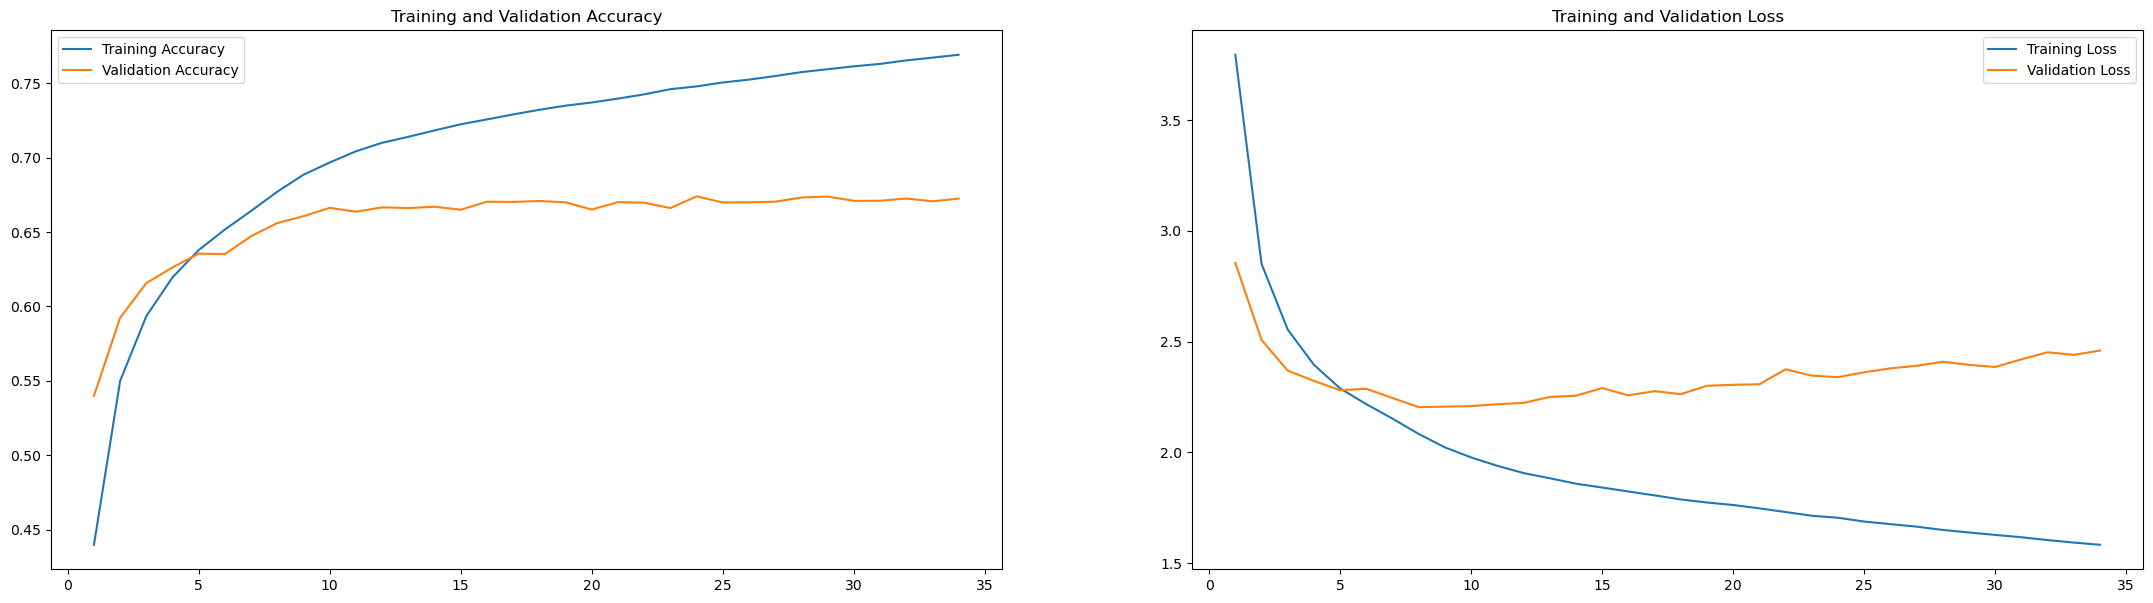

In [31]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(27,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_acc, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend();

### Testing some sentences

In [ ]:
test_model = keras.models.load_model(
    'S2S(Transformer).keras',
    custom_objects={
        'PositionalEmbedding': PositionalEmbedding,
        'TransformerEncoder': TransformerEncoder,
        'TransformerDecoder': TransformerDecoder
    }